# Image Classification with CNNs using Keras

# Task 1: Import Libraries

In [3]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU? False


# Task 2: Preprocess Data

In [4]:
def indices_of(class_id, y):
        indices, _ = np.where(y==float(class_id))
        return indices
    
def get_three_classes(x, y):    
    indices = np.concatenate([indices_of(0, y), indices_of(1, y), indices_of(2, y)],
                             axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data() 

X_train, y_train = get_three_classes(X_train, y_train)
X_test, y_test = get_three_classes(X_test, y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


# Task 3: Visualize Examples

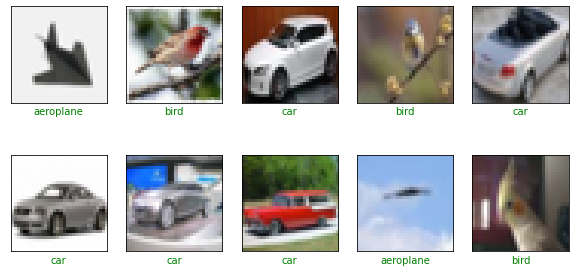

In [6]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, 1+i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
        
    plt.show()
    
show_random_examples(X_train, y_train, y_train)

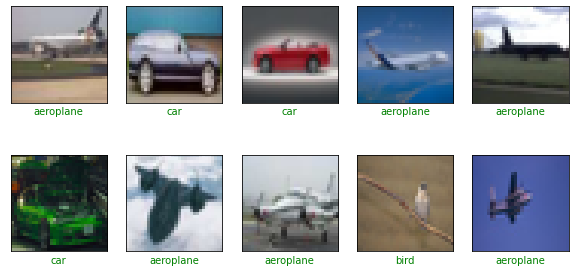

In [8]:
show_random_examples(X_test, y_test, y_test)

# Task 4: Create Model

In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def add_conv_block(model, num_filters):
    model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(num_filters, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.5))
    return model

def create_model():
    model = tf.keras.models.Sequential()
    
    model.add(Input(shape=(32, 32, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

# Task 5: Train the Model

In [15]:
%%time

h = model.fit(X_train/255., y_train,
             validation_data=(X_test/255., y_test),
             epochs=10,
             batch_size=128,
             callbacks=[
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                 tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5',
                                                    save_best_only=True,
                                                    save_weights_only=False,
                                                    monitor='val_accuracy')])



Train on 15000 samples, validate on 3000 samples
Epoch 1/10
15000/15000 [==============================] - 139s 9ms/sample - loss: 0.9162 - accuracy: 0.6745 - val_loss: 3.0308 - val_accuracy: 0.3333
Epoch 2/10
15000/15000 [==============================] - 129s 9ms/sample - loss: 0.5612 - accuracy: 0.7727 - val_loss: 2.8553 - val_accuracy: 0.3333
Epoch 3/10
15000/15000 [==============================] - 135s 9ms/sample - loss: 0.4883 - accuracy: 0.8066 - val_loss: 2.8404 - val_accuracy: 0.3650
Epoch 4/10
15000/15000 [==============================] - 127s 8ms/sample - loss: 0.4488 - accuracy: 0.8171 - val_loss: 1.5731 - val_accuracy: 0.4977
Epoch 5/10
15000/15000 [==============================] - 144s 10ms/sample - loss: 0.4193 - accuracy: 0.8346 - val_loss: 0.7967 - val_accuracy: 0.7147
Epoch 6/10
15000/15000 [==============================] - 142s 9ms/sample - loss: 0.3914 - accuracy: 0.8481 - val_loss: 0.6635 - val_accuracy: 0.7607
Epoch 7/10
15000/15000 [==========================

# Task 6: Final Predictions

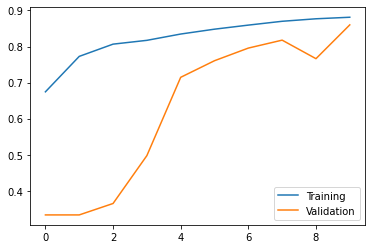

In [17]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)), accs, label='Training')
plt.plot(range(len(val_accs)), val_accs, label='Validation')
plt.legend()
plt.show()

In [18]:
model = tf.keras.models.load_model('models/model_0.860.h5')

In [19]:
prediction = model.predict(X_test/255.)

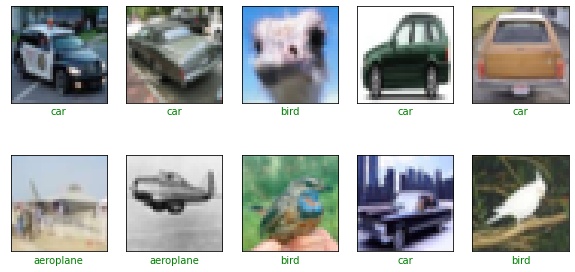

In [22]:
show_random_examples(X_test, y_test, prediction)